In [3]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent)

# **1. Item Images multicategory classification with `section_name` category**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import polars as pl
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random


from retail_recommender_system.data.loader import load_dataset, DataConfig
from retail_recommender_system.utils import read_imgs, count_model_parameters, plot_accuracy_per_class
from retail_recommender_system.training import History
from retail_recommender_system.models.mfconv import MFConvModelConfig, ImgConv

In [5]:
dataset = load_dataset(DataConfig(dataset="hm", prefix="sep_2020"))
dataset.load()

In [6]:
items_full = dataset.data['items']
items = items_full.select("article_id_map", "section_no", "path")

## Filter images:
- remove images with no path
- remove images with class cardinality <200

## Transformations:
- Remap class to new ID

In [7]:
items_processed = (
    items
    .filter(pl.col("path").is_not_null()) # Filter items without image
    .filter(pl.col("section_no").is_in(items['section_no'].value_counts(sort=True).filter(pl.col("count") > 200)['section_no'].to_numpy())) # Filter underrepresented classes (below 100)
    .with_columns(section_no_map=pl.col("section_no").cast(pl.String).cast(pl.Categorical).to_physical())
)

## Preload images to memory as tensors to speed up the process. The rest of the steps will rely on this step.
Transformations:
- Resize to (3, 128, 128). Size was selected as this is the smallest we can easily categorize manually.
- Rescale from [0, 255] to [0.0, 1.0]
- Store as float32

In [8]:
default_size = (3, 128, 128)

def _to_rgb(x):
    return x.expand(3, -1, -1)

def _to_float(x):
    return x.to(torch.float32)

def _rescale(x):
    return (x / x.max()) * 2 - 1

def _inv_rescale(x):
    return (x + 1.) / 2.

transform = transforms.Compose([
    transforms.Resize(default_size[1:]),
    _to_rgb,
    _to_float,
    _rescale,
])

images = read_imgs(list(items_processed['path'].to_numpy()), transform, default_size = default_size, tqdm_=True)

100%|██████████| 22074/22074 [03:42<00:00, 99.33it/s] 


In [ ]:
# fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# for i in range(9):
#     row = i // 3
#     col = i % 3
#     r_ix = random.randint(0, len(images))
#     ax[row, col].imshow(_inv_rescale(images[r_ix].permute(1, 2, 0)))
#     ax[row, col].axis('off')
#     ax[row, col].set_title(f"Article ID: {r_ix}")
# plt.show()

In [496]:
# transform_post = transforms.Compose([
#     #transforms.RandomHorizontalFlip(p=0.3),
#     #  transforms.RandomApply(nn.ModuleList([
#     #     transforms.Pad(10, padding_mode='reflect'),
#     #     transforms.RandomCrop(size=(128, 128)),
#     # ]), p=0.2),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     #             std=[0.229, 0.224, 0.225])
# ])

# transform_post_eval = transforms.Compose([
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     #             std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# fig, ax = plt.subplots(4, 2, figsize=(10, 15))
# for i in range(8):
#     row = i // 2

#     r_ix = random.randint(0, len(images))
#     ax[row, 0].imshow(_inv_rescale(images[r_ix].permute(1, 2, 0)))
#     ax[row, 0].set_title(f"Article ID: {r_ix}")
#     ax[row, 0].axis('off')

#     ax[row, 1].imshow(_inv_rescale(transform_post(images[r_ix]).permute(1, 2, 0)))
#     ax[row, 1].axis('off')
#     ax[row, 1].set_title(f"Article ID (transform): {r_ix}")
# plt.show()

# Split data. Used 80% for training and 20% for validation.

In [9]:
valid_size = 0.2
split_idx = int(len(items_processed) * (1 - valid_size))
train_idx = np.arange(len(items_processed))
np.random.shuffle(train_idx)

train_images, train_items = images[train_idx[:split_idx]], items_processed[train_idx[:split_idx]]
valid_images, valid_items = images[train_idx[split_idx:]], items_processed[train_idx[split_idx:]]

# Get class cardinality distribution and compute class weights used for weight multiplication in the loss functions.

Function `compute_class_weight` from package `scikit-learn` has been used to do so.

Text(0.5, 0, 'Class')

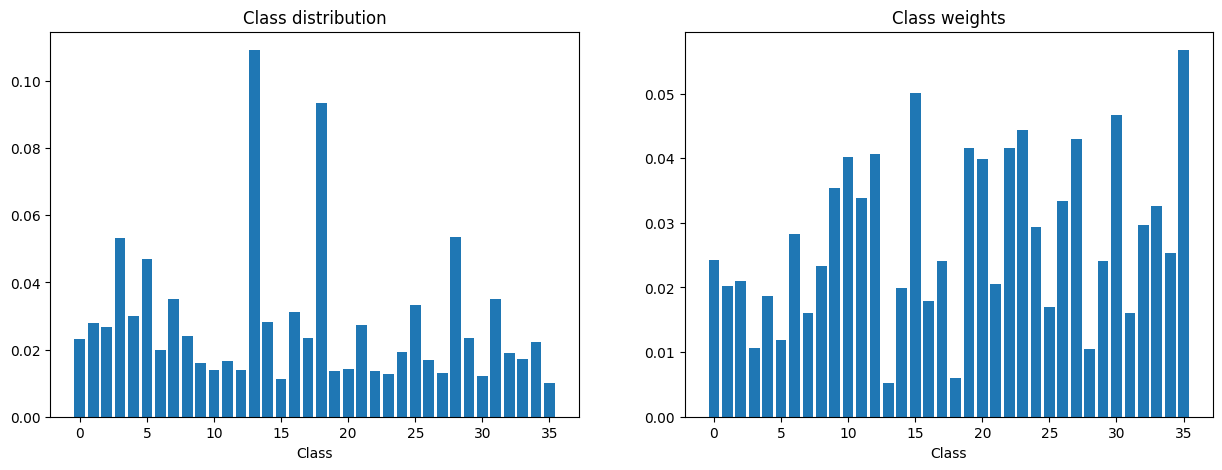

In [10]:
class_distribution = train_items['section_no_map'].value_counts(normalize=True).sort(by='section_no_map')['proportion']

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_items['section_no_map'].to_numpy()), 
    y=train_items['section_no_map'].to_numpy().flatten()
)
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.from_numpy(class_weights).to(torch.float32).to("mps")


section_no_map_uq = np.unique(train_items['section_no_map'].to_numpy())
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(section_no_map_uq, class_distribution)
ax[0].set_title("Class distribution")
ax[0].set_xlabel("Class")
ax[1].bar(section_no_map_uq, class_weights)
ax[1].set_title("Class weights")
ax[1].set_xlabel("Class")

# Set up common elements

In [17]:
class ItemsImageDataset(Dataset):
    def __init__(self, items, images, transform=None):
        self.items = items
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.items['section_no_map'][idx]

        if self.transform:
            img = self.transform(img)

        return img, label

class ItemsImagesModel(nn.Module):
    def __init__(self, config: MFConvModelConfig, num_classes: int):
        super(ItemsImagesModel, self).__init__()
        self._num_classes = num_classes
        self.conv = ImgConv(config)
        self.ff_clf = nn.Linear(config.emb_size, num_classes)

    def forward(self, x):
        x = F.relu(self.conv(x))
        return self.ff_clf(x)

class AlexNetModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AlexNetModel, self).__init__()
        assert input_size[1] == input_size[2]

        convs = (
            [
                (
                    nn.Conv2d(chs[0], chs[1], kernel_size=(k, k), stride=s), 
                    nn.ReLU(), 
                    nn.MaxPool2d(kernel_size=(3, 3), stride=2)
                ) for (chs, k, s) in [((3, 96), 11, 4), ((96, 256), 5, 1), ((256, 384), 3, 1), ((384, 256), 3, 1)]
            ]
        )
        convs = [l for ls in convs for l in ls][:9]
        self.convs = nn.Sequential(*convs)
        self.mlps = nn.Sequential(
            nn.Linear(6144, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        return self.mlps(x)
    
device = torch.device("mps")
num_classes = len(items_processed['section_no_map'].unique())
batch_size = 32
lr = 1e-3
model_config = MFConvModelConfig(n_users=-1, n_items=-1, emb_size=16, image_size=default_size, dropout=0.2)

In [21]:
def train(model, train_loader, optimizer, criterion, print_every: None | int = None):
    model.train()
    train_loss = 0.0
    preds, ground_truths = [], []

    for batch_idx, batch in enumerate(train_loader):
        data, target = [x.to(device) for x in batch]

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            percentage = 100.0 * batch_idx / len(train_loader)
            print(f"Train (Batch): [{batch_idx}/{len(train_loader)} ({percentage:.0f}%)] | Loss: {loss_item:.4f}")

        preds.append(output)
        ground_truths.append(target)
        train_loss += loss_item

    train_loss /= len(train_loader)

    pred = torch.cat(preds, dim=0).detach().softmax(dim=1).argmax(dim=1).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).detach().cpu().numpy()
    accuracy = float(accuracy_score(ground_truth, pred))
    cm = confusion_matrix(ground_truth, pred, labels=np.arange(num_classes))
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    w_accuracy = (accuracy_per_class * class_weights).sum()
    f1 = float(f1_score(ground_truth, pred, average="weighted"))

    print(f"\nTrain: Loss: {train_loss:.4f} | Accuracy: {accuracy:.4f} | Weighted Accuracy: {w_accuracy: .4f} | F1 Score: {f1:.4f}")

    return train_loss, accuracy, w_accuracy, accuracy_per_class, f1

def test(model, valid_loader, criterion):
    model.eval()
    test_loss = 0.0
    preds, ground_truths = [], []

    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_loader):
            data, target = [x.to(device) for x in batch]

            output = model(data)
            loss = criterion(output, target)

            preds.append(output)
            ground_truths.append(target)
            test_loss += loss.detach().cpu().item()
    
    test_loss /= len(valid_loader)

    pred = torch.cat(preds, dim=0).softmax(dim=1).argmax(dim=1).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
    accuracy = float(accuracy_score(ground_truth, pred))
    cm = confusion_matrix(ground_truth, pred, labels=np.arange(num_classes))
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    w_accuracy = (accuracy_per_class * class_weights).sum()
    f1 = float(f1_score(ground_truth, pred, average="weighted"))

    print(f"\nTest: Loss: {test_loss:.4f} | Accuracy: {accuracy:.4f} | Weighted Accuracy: {w_accuracy: .4f} | F1 Score: {f1:.4f}")

    return test_loss, accuracy, w_accuracy, accuracy_per_class, f1

def fit(model, train_loader, valid_loader, optimizer, criterion, epochs: int, lr_scheduler=None, print_every: None | int = None):
    history = History(metrics={"train_accuracy": [], "val_accuracy": [], "train_weighted_accuracy": [], "val_weighted_accuracy": [], "train_f1": [], "val_f1": []})

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_accuracy, train_weighted_accuracy, train_accuracy_per_class, train_f1 = train(
            model, train_loader, optimizer, criterion, print_every=print_every
        )
        valid_loss, val_accuracy, val_weighted_accuracy, val_accuracy_per_class, val_f1 = test(model, valid_loader, criterion)
        plot_accuracy_per_class(train_accuracy_per_class, val_accuracy_per_class, class_weights)

        history.log_loss(train_loss, valid_loss)
        history.metrics["train_accuracy"].append(train_accuracy)
        history.metrics["val_accuracy"].append(val_accuracy)
        history.metrics["train_weighted_accuracy"].append(train_weighted_accuracy)
        history.metrics["val_weighted_accuracy"].append(val_weighted_accuracy)
        history.metrics["train_f1"].append(train_f1)
        history.metrics["val_f1"].append(val_f1)

        if lr_scheduler is not None:
            lr_scheduler.step()
            print("LR: ", lr_scheduler.get_last_lr())
    return history

def plot_metrics(history):
    nrows = 3
    fig, ax = plt.subplots(nrows, 1, figsize=(10, 5 * nrows))

    ax[0].plot(history.train_loss, label="train loss")
    ax[0].plot(history.val_loss, label="val loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history.metrics["train_accuracy"], label="train_accuracy")
    ax[1].plot(history.metrics["val_accuracy"], label="val_accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Value")
    ax[1].legend()

    ax[2].plot(history.metrics["train_weighted_accuracy"], label="train_weighted_accuracy")
    ax[2].plot(history.metrics["val_weighted_accuracy"], label="val_weighted_accuracy")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Value")
    ax[2].legend()

    plt.show()

def plot_weight_histogram(model, layer_name=None):
    weights = []
    for name, param in model.named_parameters():
        if param.requires_grad and param.dim() > 1:  # Filter only weight tensors (e.g., Conv2d/Linear layers)
            if layer_name is None or name.startswith(layer_name):
                weights.extend(param.detach().cpu().numpy().ravel())  # Flatten the weights

    if not weights:
        print(f"No weights found for layer: {layer_name}")
        return
    
    plt.hist(weights, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Histogram of Weights{' for ' + layer_name if layer_name else ''}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Classification model training

Below trainings are chosen as most promising variants for given dataset out of given high-level parameters:
- model architectures: AlexNet-like model, Conv with small number outer channels and Conv with large number of outer channels
- CategoricalCrossentropy with/without weight and FocalLoss with/without weights
- with/without post-trasfrorm
- with/without lr scheduler \
### The process is not gridsearching over them but some sampling based on our intuition.

## Variant 1: 
- Convnet (small), 
- CategoricalCrossentropy w/o weight, 
- w/o scheduler, 
- w/o post-transform

  0%|          | 0/1 [00:00<?, ?it/s]

Train (Batch): [0/552 (0%)] | Loss: 3.6105
Train (Batch): [250/552 (45%)] | Loss: 3.7023
Train (Batch): [500/552 (91%)] | Loss: 3.0989

Train: Loss: 3.3337 | Accuracy: 0.1097 | Weighted Accuracy:  0.0114 | F1 Score: 0.0483

Test: Loss: 3.1077 | Accuracy: 0.1490 | Weighted Accuracy:  0.0188 | F1 Score: 0.0625


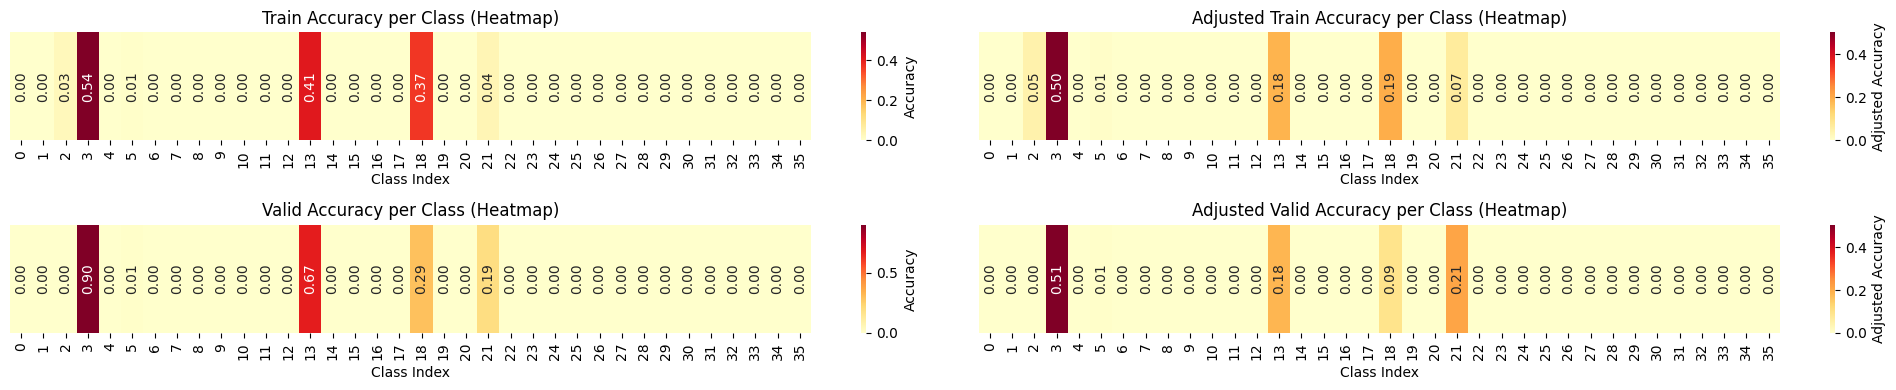

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


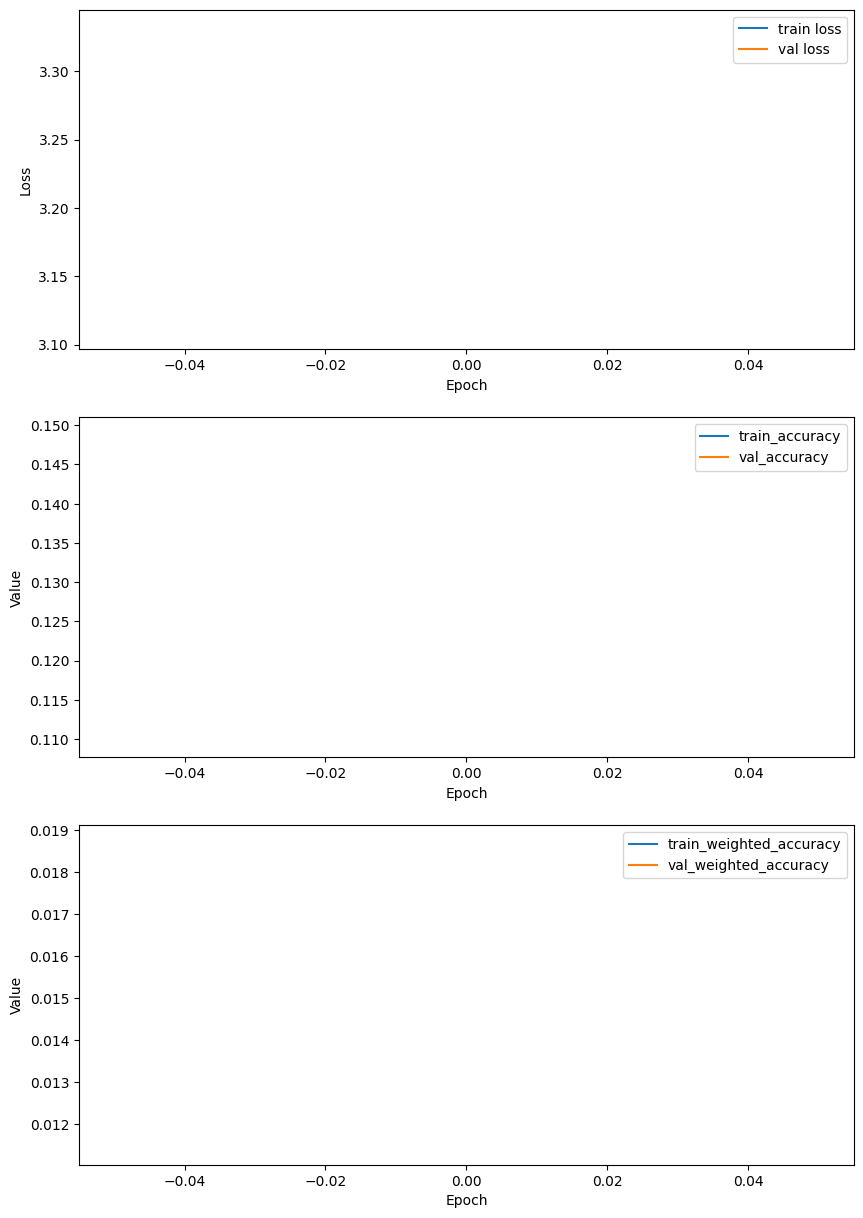

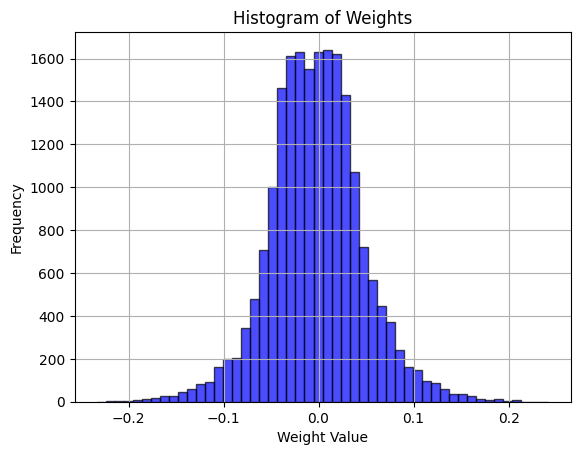

Total parameters: 20860
Trainable parameters: 20860
Non-trainable parameters: 0


{'total_params': 20860, 'trainable_params': 20860, 'non_trainable_params': 0}

In [25]:
train_dataset = ItemsImageDataset(train_items, train_images, transform=None)
valid_dataset = ItemsImageDataset(valid_items, valid_images, transform=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = ItemsImagesModel(model_config, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = fit(model, train_loader, valid_loader, optimizer, criterion, epochs=1, print_every=250)

plot_metrics(history)
plot_weight_histogram(model.conv)
count_model_parameters(model)

## Variant 2: 
- Convnet (large), 
- CategoricalCrossentropy w/o weight, 
- w/o scheduler, 
- w/o post-transform

In [ ]:
train_dataset = ItemsImageDataset(train_items, train_images, transform=None)
valid_dataset = ItemsImageDataset(valid_items, valid_images, transform=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = ItemsImagesModelLarge(model_config, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = fit(model, train_loader, valid_loader, optimizer, criterion, epochs=1, print_every=250)

plot_metrics(history)
plot_weight_histogram(model.conv)
count_model_parameters(model)

## Variant 3: 
- Convnet (small), 
- CategoricalCrossentropy with weight, 
- w/o scheduler, 
- w/o post-transform

## Variant 4: 
- AlexNet-like, 
- CategoricalCrossentropy with weight, 
- w/o scheduler, 
- w/o post-transform

## Variant 5: 
- Convnet (small), 
- FocalLoss, 
- w/o scheduler, 
- w/o post-transform

## Variant 6: 
- Convnet (small), 
- CategoricalCrossentropy with weight, 
- with scheduler, 
- with post-transform

In [507]:
transform_post = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.3),
    #  transforms.RandomApply(nn.ModuleList([
    #     transforms.Pad(10, padding_mode='reflect'),
    #     transforms.RandomCrop(size=(128, 128)),
    # ]), p=0.2),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225])
])

transform_post_eval = transforms.Compose([
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225])
])
sampler = WeightedRandomSampler(class_weights, len(class_weights))

train_dataset = ItemsImageDataset(train_items, train_images, transform=transform_post)
valid_dataset = ItemsImageDataset(valid_items, valid_images, transform=transform_post_eval)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
lr = 1e-3
model = ItemsImagesModel(model_config, num_classes).to(device)
criterion = nn.CrossEntropyLoss() #(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=999, gamma=0.5) 

In [41]:
torch.save(model.conv.state_dict(), ".models/conv.pth")

In [ ]:
model_loaded = ItemsImagesModel(model_config, num_classes)
model_loaded.conv.load_state_dict(torch.load(".models/conv.pth", weights_only=True))
plot_weight_histogram(model_loaded.conv)

for name, param in model_loaded.named_parameters():
    if name.startswith("ff_e"):
        param.requires_grad = True  # Keep ff_e trainable
    else:
        param.requires_grad = False  # Freeze all other layers

In [ ]:
count_model_parameters(model_loaded)

In [ ]:
images_full = torch.zeros(len(items), *default_size)
images_full[items_processed['article_id_map'].to_numpy()] = images
images_full[np.setdiff1d(np.arange(len(items)), items_processed['article_id_map'].to_numpy())] = images.mean(dim=0)

In [47]:
torch.save(images_full, ".data/hm/intermediate/full/images.pth")

In [44]:
model.eval()
with torch.no_grad():
    images_full_device = images_full.to(device)
    embeddings = model.conv(images_full_device).cpu()

In [ ]:
model.shape

In [48]:
torch.save(embeddings, ".models/conv.pth")